DB: You shouldn't have to ever run this again. Results are stored in year_limited_songs.csv in the project google drive folder.

In [ ]:
import os
from google.colab import drive, files
import pandas as pd
import polars as pl

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/mit/2024-25 (senior year)/6.8611/6.8611 final project/genius_song_lyrics
%cd /content/drive/MyDrive/6.8611 final project/genius_song_lyrics

raw_data = pl.read_csv('./song_lyrics.csv', columns = ['title', 'tag', 'artist', 'year', 'lyrics', 'id', 'language'])
print(raw_data.head())

/content/drive/.shortcut-targets-by-id/10KmyK1yEw0WioL8iUTO0ZpM7KwE7Ofnx/6.8611 final project/genius_song_lyrics
shape: (5, 7)
┌───────────────────┬─────┬───────────┬──────┬─────────────────────────────────┬─────┬──────────┐
│ title             ┆ tag ┆ artist    ┆ year ┆ lyrics                          ┆ id  ┆ language │
│ ---               ┆ --- ┆ ---       ┆ ---  ┆ ---                             ┆ --- ┆ ---      │
│ str               ┆ str ┆ str       ┆ i64  ┆ str                             ┆ i64 ┆ str      │
╞═══════════════════╪═════╪═══════════╪══════╪═════════════════════════════════╪═════╪══════════╡
│ Killa Cam         ┆ rap ┆ Cam'ron   ┆ 2004 ┆ [Chorus: Opera Steve & Cam'ron… ┆ 1   ┆ en       │
│ Can I Live        ┆ rap ┆ JAY-Z     ┆ 1996 ┆ [Produced by Irv Gotti]         ┆ 3   ┆ en       │
│                   ┆     ┆           ┆      ┆                                 ┆     ┆          │
│                   ┆     ┆           ┆      ┆ [Intr…                          ┆     ┆   

In [ ]:
# filtering out non-english songs & non-songs (tag = 'misc')

print('before', raw_data.shape)

only_english = raw_data.filter(pl.col('language') == 'en').drop('language')
english_songs = only_english.filter(pl.col('tag') != 'misc')

print('after', english_songs.shape)

before (5134856, 7)
after (3233212, 6)


In [ ]:
# limiting to top_n most common genres

genre_to_count = {}
top_n = 5

for name, data in english_songs.group_by('tag'):
    genre_to_count[name[0]] = data.shape[0]

top_genres_list = sorted([genre for genre in genre_to_count], key = lambda x : genre_to_count[x], reverse = True)[:top_n]
for genre in top_genres_list :
    print(genre, '->', genre_to_count[genre])

top_genres_songs = english_songs.filter(pl.col('tag').is_in(top_genres_list))

assert top_genres_songs.shape[0] == sum([genre_to_count[genre] for genre in top_genres_list]), 'Incorrect number of genre-limited songs.'

pop -> 1393559
rap -> 964605
rock -> 633308
rb -> 155082
country -> 86658


In [ ]:
# sampling data to produce consistent #s of songs per year per genre

year_range = range(1980, 2023)
year_limit = 160

year_limited_songs = top_genres_songs.filter(pl.col('tag') == 'misc') # intentionally empty DF; collects final year-limited songs

for genre in top_genres_list :
    genre_songs = top_genres_songs.filter(pl.col('tag') == genre)

    for year in year_range :
        try :
            this_years_songs = genre_songs.filter(pl.col('year') == year).sample(year_limit) # randomly sample year_limit songs
        except :
            raise Exception('The genre ' + genre + ' in year ' + str(year) + ' did not have at least ' + str(year_limit) + ' songs in the dataset.')

        year_limited_songs = pl.concat([year_limited_songs, this_years_songs], how = 'vertical') # add to collector DF


assert year_limited_songs.shape[0] == len(top_genres_list) * len(year_range) * year_limit, 'Incorrect total of year-limited songs.'

In [ ]:
# save results to google drive

year_limited_songs.write_csv("year_limited_songs.csv")
files.download('year_limited_songs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DS: some basic data viz

In [ ]:
import os
from google.colab import drive, files
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from transformers import BertTokenizer

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/'6.8611 final project'

/content/drive/.shortcut-targets-by-id/10KmyK1yEw0WioL8iUTO0ZpM7KwE7Ofnx/6.8611 final project


In [ ]:
raw_data_plot = pl.read_csv('genius_song_lyrics/song_lyrics.csv', columns = ['title', 'tag', 'artist', 'year', 'lyrics', 'id', 'language'])

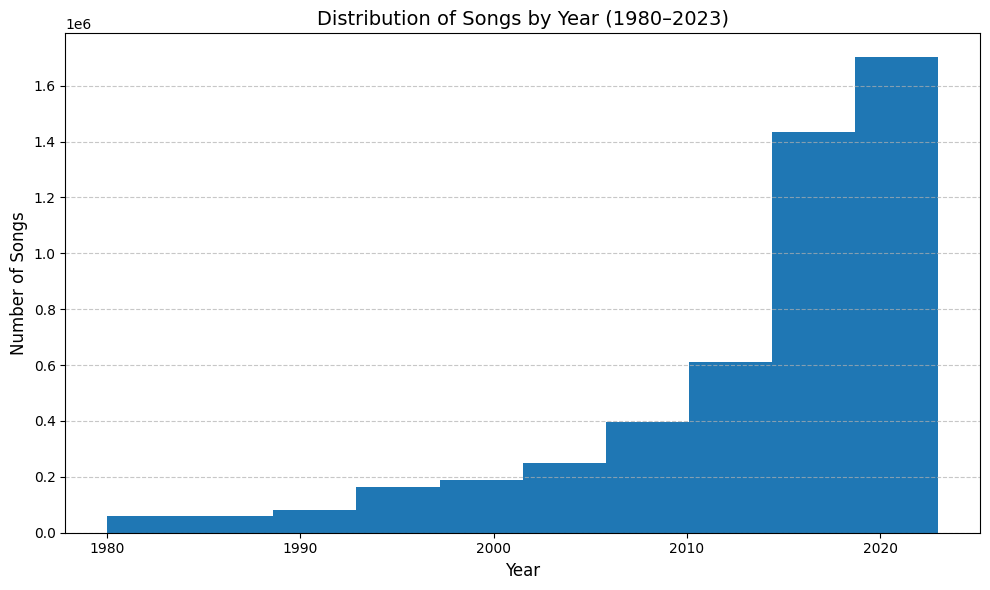

In [ ]:
years = raw_data_plot['year'].to_numpy()
filtered_years = years[(years >= 1980) & (years <= 2023)]

# plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_years, bins=10)
plt.title('Distribution of Songs by Year (1980–2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# dataset shape
raw_data_plot.shape

(5134856, 7)

In [ ]:
# filtering out for english
eng_data = raw_data_plot.filter((pl.col('language') == 'en') & (pl.col('tag') != 'misc')).drop('language')

In [ ]:
print(eng_data.columns)

['title', 'tag', 'artist', 'year', 'lyrics', 'id']


In [ ]:
# just curious: are there rows without lyrics? (answer: no)
eng_data.filter(pl.col('lyrics').is_null())

title,tag,artist,year,lyrics,id
str,str,str,i64,str,i64


In [ ]:
# types of genres and their frequency
genre_counts = (
    eng_data
    .group_by("tag")
    .agg(pl.len().alias("count"))
).sort("count", descending=True)

In [ ]:
genre_counts

tag,count
str,u32
"""pop""",1393559
"""rap""",964605
"""rock""",633308
"""rb""",155082
"""country""",86658


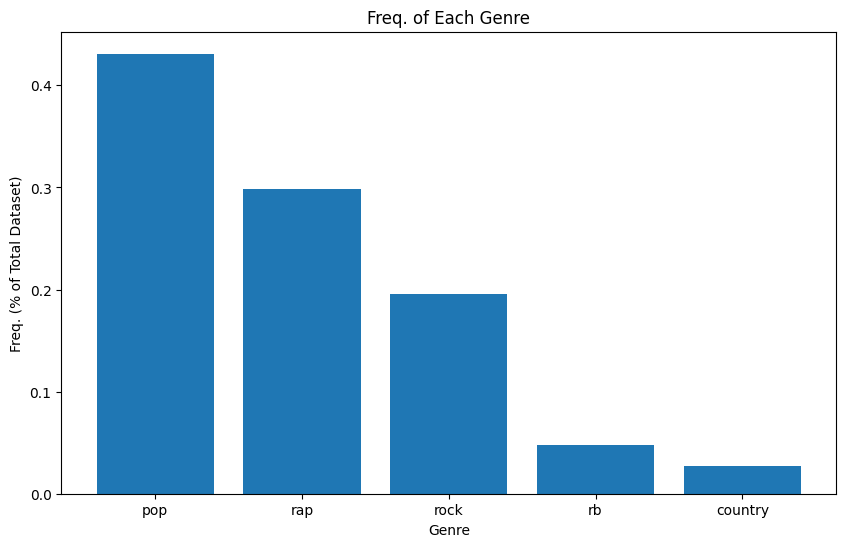

In [ ]:
genre_counts_pd = genre_counts.to_pandas()
plt.figure(figsize=(10, 6))
plt.bar(genre_counts_pd['tag'], genre_counts_pd['count']/genre_counts_pd['count'].sum())
plt.xlabel("Genre")
plt.ylabel("Freq. (% of Total Dataset)")
plt.title("Freq. of Each Genre")
plt.show()

In [ ]:
# looking at lyrics (on avg. how many tokens per datapoint/row) (using bert-base-uncased as an example)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def count_bert_tokens(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

token_counts = eng_data.sample(n=1000, seed=42).with_columns([
    pl.col("lyrics").map_elements(count_bert_tokens).alias("bert_token_count")
])

<ipython-input-12-b4d1c3126efe>:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  token_counts = eng_data.sample(n=1000, seed=42).with_columns([


In [ ]:
token_counts['bert_token_count']

title,tag,artist,year,lyrics,id,bert_token_count
str,str,str,i64,str,i64,i64
"""Forevermore""","""pop""","""Joe Pisapia""",2001,"""I only want to be close to you…",1067795,86
"""Beautiful""","""pop""","""Brandyn Hazelton""",2010,"""I see you there, lying in the …",1716702,333
"""Seether""","""rock""","""Veruca Salt""",1994,"""Ow! Seether is neither loose …",1677931,286
"""Am Yours""","""rap""","""Jozeph Asa""",2020,"""[Hook] I had an illusion, I ha…",5479900,615
"""FlatBed Freestyle Minecraft Re…","""rap""","""CHRIZI""",2018,"""[Intro] (Buh, buh, buh, buh, b…",3925680,394
…,…,…,…,…,…,…
"""Up to you""","""rb""","""Faith McCaine""",2019,"""[verse 1:] I usually just run …",4205623,647
"""​glow up""","""rap""","""wolfacejoeyy""",2021,"""[Intro] (Yo, Arena) [Chorus] …",6582230,581
"""Reappear""","""pop""","""School of Seven Bells""",2012,"""You know it's time to find the…",836547,93


In [ ]:
top_rap_song = token_counts.sort("bert_token_count", descending=True).head(1)

top_rap_song

title,tag,artist,year,lyrics,id,bert_token_count
str,str,str,i64,str,i64,i64
"""Real Deal vs Math Hoffa""","""rap""","""King of the Dot""",2018,"""[Round 1: Math Hoffa] In this …",3731520,4192


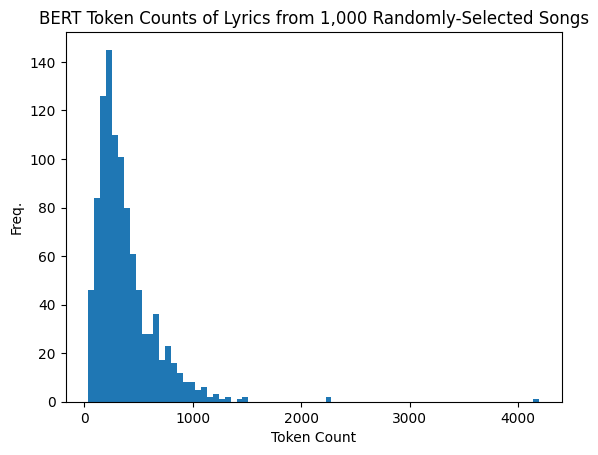

In [ ]:
# histogram of bert token counts for 1,000 Randomly-Selected Songs
plt.hist(token_counts['bert_token_count'], bins='auto')
plt.xlabel("Token Count")
plt.ylabel("Freq.")
plt.title("BERT Token Counts of Lyrics from 1,000 Randomly-Selected Songs")
plt.show()

In [ ]:
# summary statistics (mean = 375, std=282)
token_counts['bert_token_count'].describe()

statistic,value
str,f64
"""count""",1000.0
"""null_count""",0.0
"""mean""",375.906
"""std""",282.776891
"""min""",37.0
"""25%""",198.0
"""50%""",306.0
"""75%""",473.0
"""max""",4192.0


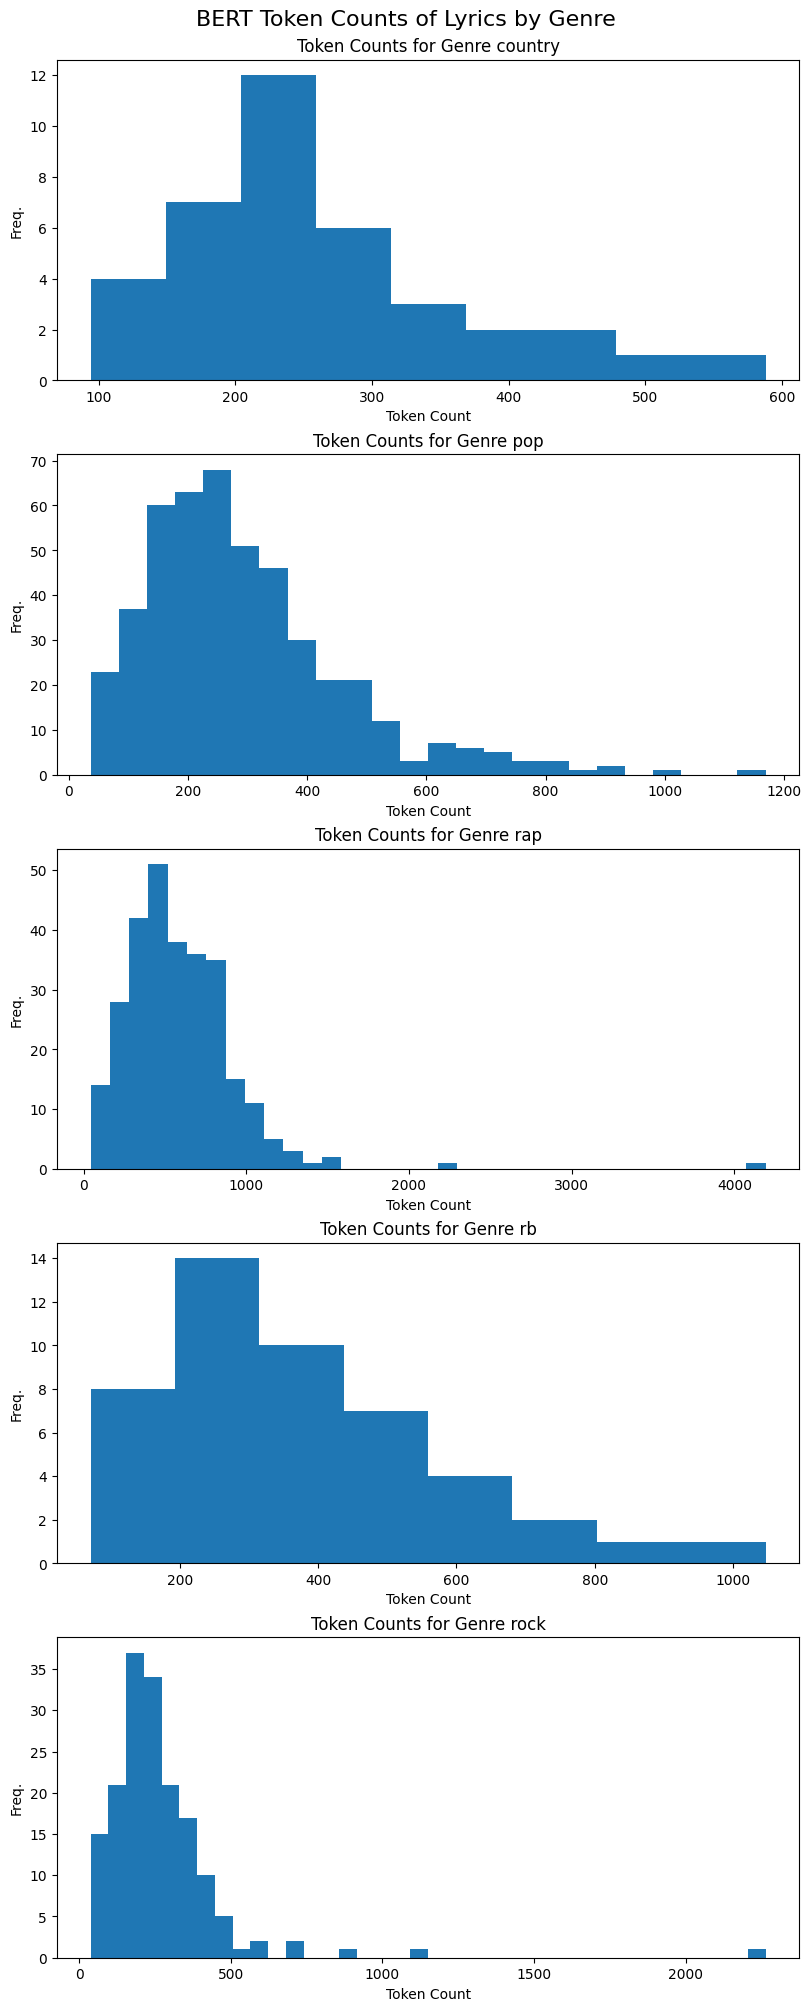

In [ ]:
# same plot as above but by genre (won't include this as a plot though, takes up too much space so using a table instead.)
token_counts_pd = token_counts.to_pandas()
genres = token_counts_pd['tag'].unique()
n_genres = len(genres)

fig, axs = plt.subplots(n_genres, 1, figsize=(8, 4 * n_genres), constrained_layout=True)

for i, genre in enumerate(grouped_data):
    ax = axs[i] if n_genres > 1 else axs
    genre_data = token_counts_pd[token_counts_pd['tag'] == genre]['bert_token_count']
    ax.hist(genre_data, bins='auto')
    ax.set_title(f"Token Counts for Genre {genre}")
    ax.set_xlabel("Token Count")
    ax.set_ylabel("Freq.")

plt.suptitle("BERT Token Counts of Lyrics by Genre", fontsize=16)
plt.show()

In [ ]:
token_counts.group_by("tag").agg([
    pl.col("bert_token_count").mean().alias("mean"),
    pl.col("bert_token_count").median().alias("median"),
    pl.col("bert_token_count").min().alias("min"),
    pl.col("bert_token_count").max().alias("max"),
    pl.col("bert_token_count").std().alias("std_dev"),
    pl.col("bert_token_count").count().alias("count_songs")
])

tag,mean,median,min,max,std_dev,count_songs
str,f64,f64,i64,i64,f64,u32
"""rock""",268.095238,235.0,38,2264,214.267761,168
"""pop""",293.717672,252.5,37,1169,169.529128,464
"""rb""",379.765957,341.0,71,1047,211.354659,47
"""country""",264.763158,245.5,94,588,107.193796,38
"""rap""",588.943463,544.0,43,4192,367.220821,283
